In [1]:
%matplotlib inline

In [2]:
import os 
import sys 
import pathlib

In [3]:
HOME = pathlib.Path.home()

In [4]:
from matplotlib import pyplot as plt

In [5]:
import numpy as np 
import pandas as pd

In [6]:
from pycaret import datasets

In [7]:
from pycaret.classification import *

In [8]:
data = pd.read_csv(HOME / 'research' / 'Smart_Ideas' / 'outputs' / 'CSVs' / 'GCMs_and_targets_cat3_and_anomalies_TMEAN_training_set.csv', \
                   index_col=0, parse_dates=True) 

### extract JUST THE GCM data and the GCM label 

In [9]:
GCM_data = data.iloc[:,0:-12]

### extract the GCM label 

In [10]:
GCM = data.loc[:,['GCM']]

### extract the target variable 

In [11]:
target = data.loc[:,['NNI_cat3_categories']]

In [12]:
target.head()

,NNI_cat3_categories
1993-04-30,1
1993-05-31,1
1993-06-30,1
1993-07-31,2
1993-08-31,1


### extract just ONE GCM from the GCM data 

In [13]:
data = pd.concat([GCM_data, target], axis=1) 

In [14]:
data.shape

(3982, 4931)

In [15]:
GCM_data.shape

(3982, 4930)

In [16]:
data = data.query("GCM == 'ECMWF'")

In [17]:
data.shape

(288, 4931)

In [18]:
data.drop('GCM', axis=1, inplace=True)

In [19]:
data.shape

(288, 4930)

In [20]:
data.columns

Index(['(-70.0, 70.0)', '(-70.0, 72.5)', '(-70.0, 75.0)', '(-70.0, 77.5)',
       '(-70.0, 80.0)', '(-70.0, 82.5)', '(-70.0, 85.0)', '(-70.0, 87.5)',
       '(-70.0, 90.0)', '(-70.0, 92.5)',
       ...
       '(60.0, 280.0)', '(60.0, 282.5)', '(60.0, 285.0)', '(60.0, 287.5)',
       '(60.0, 290.0)', '(60.0, 292.5)', '(60.0, 295.0)', '(60.0, 297.5)',
       '(60.0, 300.0)', 'NNI_cat3_categories'],
      dtype='object', length=4930)

In [21]:
exp_clf = setup(data = data, target = 'NNI_cat3_categories', session_id=123,
                  normalize = False, 
                  transformation = False, 
                  pca=True, pca_components=0.9)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Multiclass
2,Label Encoded,None
3,Original Data,"(288, 4930)"
4,Missing Values,False
5,Numeric Features,4929
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [22]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,CatBoost Classifier,0.5867,0,0.5395,0.595,0.5677,0.3381
1,Extra Trees Classifier,0.5819,0,0.5203,0.5729,0.5432,0.3118
2,Extreme Gradient Boosting,0.5676,0,0.5306,0.5588,0.5532,0.3156
3,Quadratic Discriminant Analysis,0.5624,0,0.498,0.5671,0.5216,0.2829
4,Light Gradient Boosting Machine,0.5624,0,0.521,0.5773,0.5586,0.3128
5,Gradient Boosting Classifier,0.5621,0,0.5254,0.5711,0.5452,0.3108
6,K Neighbors Classifier,0.5469,0,0.5084,0.5327,0.5265,0.2784
7,Random Forest Classifier,0.5371,0,0.4799,0.5322,0.4984,0.2416
8,Decision Tree Classifier,0.5224,0,0.4565,0.5071,0.4779,0.214
9,Naive Bayes,0.5171,0,0.4917,0.5369,0.5053,0.2552


In [29]:
#blend all models
blend_all = blend_models()
#create models for blending
lr = create_model('qda')
rf = create_model('et')
knn = create_model('xgboost')
#blend trained models
blend_specific = blend_models(estimator_list = [lr,rf,knn])

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.5714,0.0,0.5545,0.6022,0.5624,0.3102
1,0.6500,0.0,0.5778,0.6815,0.6201,0.4239
2,0.4500,0.0,0.4296,0.4670,0.4570,0.1571
3,0.7000,0.0,0.6333,0.6842,0.6744,0.5142
4,0.5000,0.0,0.4296,0.4019,0.4384,0.1837
5,0.6500,0.0,0.5889,0.6268,0.5938,0.4215
6,0.7000,0.0,0.6815,0.7089,0.7013,0.5331
7,0.4500,0.0,0.3333,0.2700,0.3375,0.0678
8,0.6000,0.0,0.5889,0.6455,0.6075,0.3600
9,0.7500,0.0,0.7296,0.7750,0.7451,0.5968


In [32]:
blend_all = blend_models()

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.6190,0.0,0.6021,0.6548,0.6181,0.3913
1,0.6000,0.0,0.5704,0.6025,0.5982,0.3701
2,0.3500,0.0,0.3556,0.4495,0.3746,0.0335
3,0.5500,0.0,0.4926,0.5411,0.5440,0.2996
4,0.5000,0.0,0.4481,0.4714,0.4807,0.2032
5,0.6000,0.0,0.6000,0.5900,0.5933,0.3725
6,0.7000,0.0,0.7000,0.7875,0.7142,0.5489
7,0.5000,0.0,0.4185,0.4700,0.4835,0.2157
8,0.5000,0.0,0.4667,0.5117,0.4912,0.1903
9,0.7000,0.0,0.6333,0.7643,0.6750,0.5000


In [33]:
tuned_xgboost = tune_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.7143,0.0,0.6974,0.7167,0.7126,0.5532
1,0.8000,0.0,0.7667,0.8125,0.7879,0.6774
2,0.4500,0.0,0.4481,0.4917,0.4568,0.1506
3,0.7500,0.0,0.7185,0.7773,0.7500,0.6032
4,0.5000,0.0,0.4593,0.4364,0.4650,0.2063
5,0.5000,0.0,0.4963,0.5000,0.5000,0.2248
6,0.6500,0.0,0.6074,0.6348,0.6358,0.4422
7,0.4000,0.0,0.3148,0.3750,0.3861,0.0588
8,0.6000,0.0,0.5704,0.6000,0.5867,0.3548
9,0.6000,0.0,0.5704,0.5939,0.5908,0.3625


In [35]:
lr = create_model('qda')
rf = create_model('et')
knn = create_model('xgboost')
#blend trained models
blend_specific = blend_models(estimator_list = [lr,rf,knn])

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.5714,0.0,0.5545,0.6022,0.5624,0.3102
1,0.6500,0.0,0.5778,0.6815,0.6201,0.4239
2,0.4500,0.0,0.4296,0.4670,0.4570,0.1571
3,0.7000,0.0,0.6333,0.6842,0.6744,0.5142
4,0.5000,0.0,0.4296,0.4019,0.4384,0.1837
5,0.6500,0.0,0.5889,0.6268,0.5938,0.4215
6,0.7000,0.0,0.6815,0.7089,0.7013,0.5331
7,0.4500,0.0,0.3333,0.2700,0.3375,0.0678
8,0.6000,0.0,0.5889,0.6455,0.6075,0.3600
9,0.7500,0.0,0.7296,0.7750,0.7451,0.5968


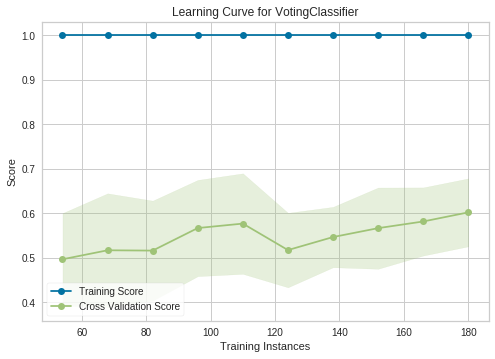

In [47]:
f = plot_model(blend_specific, plot='learning')

In [39]:
dt_boosted = create_model('xgboost', ensemble = True, method = 'Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.4286,0.0,0.3333,0.1837,0.2571,0.0
1,0.4500,0.0,0.3333,0.2025,0.2793,0.0
2,0.4500,0.0,0.3333,0.2025,0.2793,0.0
3,0.4500,0.0,0.3333,0.2025,0.2793,0.0
4,0.4500,0.0,0.3333,0.2025,0.2793,0.0
5,0.4500,0.0,0.3333,0.2025,0.2793,0.0
6,0.4500,0.0,0.3333,0.2025,0.2793,0.0
7,0.4500,0.0,0.3333,0.2025,0.2793,0.0
8,0.4500,0.0,0.3333,0.2025,0.2793,0.0
9,0.4500,0.0,0.3333,0.2025,0.2793,0.0


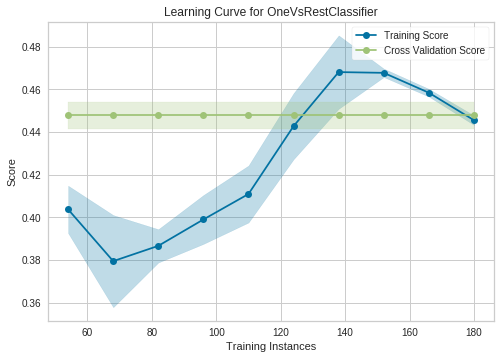

In [48]:
f = plot_model(dt_boosted, plot='learning')

In [37]:
calibrated_dt = calibrate_model(dt_boosted)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.4286,0.0,0.3333,0.1837,0.2571,0.0000
1,0.4500,0.0,0.3333,0.2025,0.2793,0.0000
2,0.5500,0.0,0.4667,0.4750,0.4429,0.2105
3,0.4500,0.0,0.3333,0.2025,0.2793,0.0000
4,0.4500,0.0,0.3333,0.2132,0.2893,0.0179
5,0.4500,0.0,0.3333,0.2250,0.3000,0.0308
6,0.6000,0.0,0.5111,0.7031,0.5407,0.3133
7,0.4500,0.0,0.3333,0.2700,0.3375,0.0678
8,0.4500,0.0,0.3333,0.2132,0.2893,0.0135
9,0.5000,0.0,0.3889,0.5132,0.3750,0.1031


In [27]:
dt = create_model('catboost', fold = 10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.6667,0.0,0.6392,0.7018,0.6569,0.4635
1,0.5500,0.0,0.4741,0.6269,0.5106,0.2562
2,0.5000,0.0,0.4963,0.5170,0.5070,0.2337
3,0.6000,0.0,0.5111,0.5408,0.5573,0.3522
4,0.5000,0.0,0.4481,0.4714,0.4807,0.2032
5,0.6000,0.0,0.5407,0.5867,0.5769,0.3522
6,0.6500,0.0,0.6333,0.7375,0.6480,0.4574
7,0.4000,0.0,0.2963,0.3000,0.3429,0.0323
8,0.6500,0.0,0.6259,0.6925,0.6511,0.4332
9,0.7500,0.0,0.7296,0.7750,0.7451,0.5968


In [25]:
dt = create_model('dt') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.5238,0.0,0.4688,0.5119,0.4966,0.2336
1,0.5000,0.0,0.4481,0.4840,0.4714,0.1803
2,0.5000,0.0,0.4667,0.5000,0.4883,0.1935
3,0.5500,0.0,0.5037,0.5492,0.5341,0.2713
4,0.4500,0.0,0.3704,0.4423,0.4197,0.1020
5,0.4000,0.0,0.3556,0.3455,0.3700,0.0476
6,0.6000,0.0,0.5296,0.6871,0.5600,0.3305
7,0.5000,0.0,0.3889,0.3450,0.3975,0.1525
8,0.6500,0.0,0.5889,0.8031,0.5972,0.4043
9,0.5500,0.0,0.4444,0.4031,0.4440,0.2241


In [26]:
ensembled_dt = ensemble_model(dt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.5238,0.0,0.4878,0.5119,0.5022,0.2500
1,0.5000,0.0,0.4185,0.5650,0.4433,0.1525
2,0.4500,0.0,0.4593,0.4679,0.4537,0.1698
3,0.5000,0.0,0.4074,0.4250,0.4213,0.1416
4,0.5500,0.0,0.4963,0.4210,0.4754,0.2941
5,0.6500,0.0,0.5778,0.6282,0.6132,0.4262
6,0.5500,0.0,0.5407,0.5667,0.5464,0.2969
7,0.3000,0.0,0.2222,0.2455,0.2700,-0.1200
8,0.6000,0.0,0.5593,0.6649,0.5963,0.3574
9,0.5500,0.0,0.4852,0.5269,0.5023,0.2683
